# Downloading data

In [30]:
import torch
import statsmodels.api as sm
import yfinance as yf

# Other files
import utils
from models.autowarp import AutoWarp
from models.mean_variance_optimisation import MeanVarianceOptimisation
from models.autoencoders import LinearAutoencoder, ConvAutoencoder, ConvLinearAutoEncoder, train_autoencoder

# General imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import json

# Optimisation
from pypfopt.expected_returns import mean_historical_return
from pypfopt.hierarchical_portfolio import HRPOpt

# Set seed for reproducibility
torch.manual_seed(0)
np.random.seed(0);

In [2]:
# 2 years training (split into 1 year train and 1 year valid), 18 months test
start_date = '2018-03-01'
valid_date = '2019-03-01'
train_date = '2020-03-01'
end_date   = '2021-09-01'

prices_train, _, _, prices_test = utils.split_prices(start_date=start_date, valid_date=valid_date, train_date=train_date, end_date=end_date, train_valid_split=2/3)
data_train, _ = utils.split_orbis_data(start_date=start_date, valid_date=valid_date, train_date=train_date, returns=True, momentum=True, train_valid_split=2/3)

# Open json file
with open(f'params/sp500_{start_date}.json') as f:
    params = json.load(f)

num_epochs=20

In [3]:
# S&P 500
sp500 = yf.download("^GSPC", start=train_date, end=end_date, period="1d")['Adj Close']
sp500 = sp500.div(sp500.iloc[0]).mul(100)

[*********************100%***********************]  1 of 1 completed


# Calculating autoencoder distance matrix

In [9]:
models = {}
models['Linear'] = train_autoencoder(LinearAutoencoder, input_size=data_train.shape[1], num_epochs=num_epochs, data=data_train, verbose=True, **params['Linear']['autoencoder'])
models['CNN'] = train_autoencoder(ConvAutoencoder, input_size=data_train.shape[1], num_epochs=num_epochs, data=data_train, verbose=True, **params['CNN']['autoencoder'])
models['Linear + CNN'] =train_autoencoder(ConvLinearAutoEncoder, input_size=data_train.shape[1], num_epochs=num_epochs, data=data_train, verbose=True, **params['Linear + CNN']['autoencoder'])

LinearAutoencoder
Epoch [1/20], Loss: 0.1269
Epoch [2/20], Loss: 0.0345
Epoch [3/20], Loss: 0.0191
Epoch [4/20], Loss: 0.0170
Epoch [5/20], Loss: 0.0156
Epoch [6/20], Loss: 0.0151
Epoch [7/20], Loss: 0.0146
Epoch [8/20], Loss: 0.0143
Epoch [9/20], Loss: 0.0140
Epoch [10/20], Loss: 0.0136
Epoch [11/20], Loss: 0.0133
Epoch [12/20], Loss: 0.0129
Epoch [13/20], Loss: 0.0123
Epoch [14/20], Loss: 0.0117
Epoch [15/20], Loss: 0.0110
Epoch [16/20], Loss: 0.0102
Epoch [17/20], Loss: 0.0095
Epoch [18/20], Loss: 0.0089
Epoch [19/20], Loss: 0.0085
Epoch [20/20], Loss: 0.0082
ConvAutoencoder
Epoch [1/20], Loss: 0.1427
Epoch [2/20], Loss: 0.0859
Epoch [3/20], Loss: 0.0703
Epoch [4/20], Loss: 0.0647
Epoch [5/20], Loss: 0.0538
Epoch [6/20], Loss: 0.0464
Epoch [7/20], Loss: 0.0382
Epoch [8/20], Loss: 0.0313
Epoch [9/20], Loss: 0.0272
Epoch [10/20], Loss: 0.0238
Epoch [11/20], Loss: 0.0218
Epoch [12/20], Loss: 0.0198
Epoch [13/20], Loss: 0.0182
Epoch [14/20], Loss: 0.0173
Epoch [15/20], Loss: 0.0165
Epoc

In [10]:
%%time
dist_matrices = {}
for model in ['Linear', 'Linear + CNN', 'CNN']:
    print(model)
    learner = AutoWarp(models[model], data_train, **params[model]['dist_matrix'])
    learner.learn_metric(verbose=True)
    dist_matrices[model] = learner.create_distance_matrix()

Linear
Alpha: 0.5124322175979614
Gamma: 0.3940407633781433
Epsilon: 0.2059236764907837
Linear + CNN
Alpha: 0.41485166549682617
Gamma: 0.911245584487915
Epsilon: 0.13439273834228516
CNN
Alpha: 0.9303330779075623
Gamma: 0.7318050265312195
Epsilon: 0.254578173160553
CPU times: total: 1min 16s
Wall time: 20.6 s


# Fama-French 3 factor model covariance matrix

In [14]:
factor_data = pd.read_csv('data/F-F_Research_Data_Factors_daily.CSV', index_col=0, parse_dates=True, skiprows=4, date_parser=lambda x:pd.to_datetime(x, format='%Y%m%d'), nrows=25419)

In [15]:
# Merge returns_train and factor_data on index
returns_train = prices_train.pct_change().dropna()
returns_train = returns_train.merge(factor_data['RF'], left_index=True, right_index=True, how='left')

# Subtract RF from all columns
returns_train = returns_train.sub(returns_train['RF'], axis=0)
returns_train = returns_train.drop(columns=['RF'])

# Merge returns_train and factor_data on index
returns_train = returns_train.merge(factor_data.drop(columns=['RF']), left_index=True, right_index=True, how='left')

In [17]:
# Estimate factor loadings
factor_loadings = {}
for stock in prices_train.columns:
    X = sm.add_constant(returns_train[['Mkt-RF', 'SMB', 'HML']])
    y = returns_train[stock]
    model = sm.OLS(y, X).fit()
    factor_loadings[stock] = model.params

# Calculate factor covariance matrix
factor_cov_matrix = returns_train[['Mkt-RF', 'SMB', 'HML']].cov()

In [18]:
# Calculate idiosyncratic variances
idiosyncratic_vars = {}
for stock in prices_train.columns:
    X = sm.add_constant(returns_train[['Mkt-RF', 'SMB', 'HML']])
    y = returns_train[stock]
    residuals = sm.OLS(y, X).fit().resid
    idiosyncratic_vars[stock] = residuals.var()

In [20]:
# Construct the covariance matrix
stocks = prices_train.columns
multi_factor_cov_matrix = pd.DataFrame(np.zeros((len(stocks), len(stocks))), index=stocks, columns=stocks)

for i in stocks:
    for j in stocks:
        multi_factor_cov_matrix.loc[i, j] = (factor_loadings[i][1:] * factor_loadings[j][1:] * factor_cov_matrix).sum().sum()
        if i == j:
            multi_factor_cov_matrix.loc[i, j] += idiosyncratic_vars[i]

# Mean variance optimisation

In [31]:
# Empty dict for weights
weights = {}

for model in ["Linear", "CNN", "Linear + CNN"]:

    # Setup
    e_returns = mean_historical_return(prices_train)
    optimiser = MeanVarianceOptimisation(expected_returns = e_returns, prices = prices_train, solver='OSQP', weight_bounds = (0,1))

    # Get weights
    risk_matrix = optimiser.make_risk_matrix(dist_matrices[model], **params[model]['risk_matrix'])
    weights[model], train_sr = optimiser.max_sharpe_ratio(risk_matrix=risk_matrix, l2_reg=0)

    # Print out summary
    print(model, train_sr)

#for model in ["Covariance", "Covariance Shrinkage", "Exponentially Weighted Covariance"]:
for model in ["Covariance", "Covariance Shrinkage"]:

    # Setup
    e_returns = mean_historical_return(prices_train)
    optimiser = MeanVarianceOptimisation(expected_returns = e_returns, prices = prices_train, solver='OSQP', weight_bounds = (0,1))

    # Get weights
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        risk_matrix = optimiser.benchmark_matrix(model)
        weights[model], train_sr = optimiser.max_sharpe_ratio(risk_matrix=risk_matrix, l2_reg=0)

    # Print out summary
    print(model, train_sr)

# Factor model
e_returns = mean_historical_return(prices_train)
optimiser = MeanVarianceOptimisation(expected_returns = e_returns, prices = prices_train, solver='OSQP', weight_bounds = (0,1))
weights['Fama-French 3 factor'], train_sr = optimiser.max_sharpe_ratio(risk_matrix=multi_factor_cov_matrix, l2_reg=0)
print("Fama-French 3 factor", train_sr)

# HRP
rets = (prices_train/prices_train.shift(1)-1).dropna()
hrp = HRPOpt(rets)
hrp.optimize()
weights['HRP'] = pd.DataFrame.from_dict(hrp.clean_weights(), orient='index', columns=['weights'])
train_sr = utils.calculate_sharpe_ratio(prices = prices_test, weights = weights['HRP'])
print("HRP", train_sr)

# Equal weights
weights['Equal'] = weights['Linear'].copy()
weights['Equal']['weights'] = 1/weights['Linear']['weights'].shape[0]
print("Equal", utils.calculate_sharpe_ratio(weights=weights['Equal'], prices=prices_train))

Linear 0.46782429501974404
CNN 0.40139774548913526
Linear + CNN 0.39448387426231213
Covariance 2.2391183250453772
Covariance Shrinkage 2.233736927603213


C:\Users\roryc\miniconda3\envs\metric_learning_env\lib\site-packages\cvxpy\problems\problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Fama-French 3 factor 1.9640103732017031
HRP 0.9347582048546635
Equal 0.47420139186000193


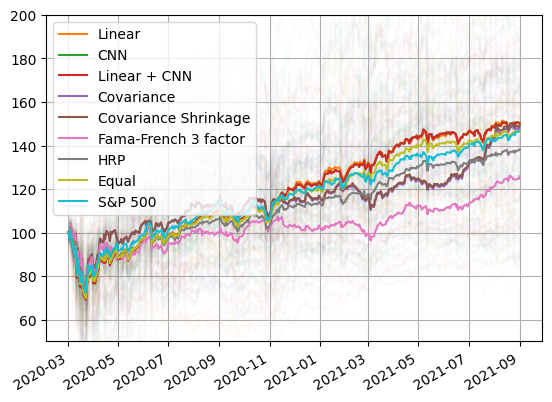

In [32]:
# Plots
plt.plot(prices_test, alpha=0.025)
for model in ["Linear", "CNN", "Linear + CNN", "Covariance", "Covariance Shrinkage", "Fama-French 3 factor", "HRP", "Equal"]:
    plt.plot(prices_test @ weights[model], label=model)
plt.plot(sp500, label="S&P 500")
plt.ylim(50, 200)
plt.grid()
plt.gcf().autofmt_xdate()
plt.legend();

In [33]:
# Sharpe ratios
rf = 0.02

# Sharpe ratio for each model
for model in ["Linear", "CNN", "Linear + CNN", "Covariance", "Covariance Shrinkage", "Fama-French 3 factor", "HRP", "Equal"]:
    print(model, "sharpe",  utils.calculate_sharpe_ratio(prices = prices_test, weights = weights[model]))
    #print(model, "std",utils.calculate_sd(prices = prices_test, weights = weights[model]))

# Sharpe ratio for equal weights
sp500_returns =((sp500/sp500.shift(1))-1).dropna()
with warnings.catch_warnings(record=True):
    warnings.simplefilter("always")
    effr = pd.read_excel('data/EFFR.xlsx', sheet_name='Results', index_col=0, usecols='A:C', engine="openpyxl")
effr = effr.drop(columns='Rate Type', axis=1)
effr.index = pd.to_datetime(effr.index)
effr['Rate (%)'] = effr['Rate (%)'] / (100*252)

sp500_returns = pd.merge(sp500_returns, effr, how='left', left_index=True, right_index=True)
sp500_returns['Rate (%)'] = sp500_returns['Rate (%)'].fillna(method='ffill')
assert sp500_returns.isnull().sum().sum() == 0
sp500_returns['excess_returns'] = sp500_returns['Adj Close'] - sp500_returns['Rate (%)']

# Calculate Sharpe Ratio
avg_return = sp500_returns['excess_returns'].mean() * 252
std = sp500_returns['excess_returns'].std() * np.sqrt(252)
sharpe = avg_return / std
print("S&P 500", sharpe)

Linear sharpe 1.0648328606174557
CNN sharpe 1.059716875514643
Linear + CNN sharpe 1.059335440767345
Covariance sharpe 1.0115514403082764
Covariance Shrinkage sharpe 1.0304578088936256
Fama-French 3 factor sharpe 0.6631606724805549
HRP sharpe 0.9347582048546635
Equal sharpe 1.0279150924261684
S&P 500 1.030778242127635


In [34]:
for model in ["Linear", "CNN", "Linear + CNN", "Covariance", "Covariance Shrinkage", "Fama-French 3 factor", "HRP", "Equal"]:
    print(model, "number of stocks included:", np.count_nonzero(weights[model]))

Linear number of stocks included: 144
CNN number of stocks included: 181
Linear + CNN number of stocks included: 181
Covariance number of stocks included: 8
Covariance Shrinkage number of stocks included: 9
Fama-French 3 factor number of stocks included: 20
HRP number of stocks included: 181
Equal number of stocks included: 181
